# DO NOT RUN this notebook

This notebook has code snippets for reference only. Do not run this notebook during the workshop. 

## Interactive agentic flows with return of control: interact with a user during execution time for additional inputs

Sometimes, additional input might be required to execute a tool or to solve a higher level task. In this case, we need to return control back to the user to collect human feedback. In LangGraph this can be implemented through a breakpoint-like concept: we stop graph execution at a specific step. At this breakpoint, we can wait for human input. Once we have input from the user, we can add it to the graph state and proceed. In what follows, we will extend our agentic assistant to support user interaction through return of control.

### Additional tool: AskHuman

Since we want to involve the user into our flow, we need to create a separate tool for that. We call it `AskHuman`.

In [ ]:
from pydantic import BaseModel

class AskHuman(BaseModel):
    """Ask missing information from the user"""

    question: str

## Agent

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant capable of providing travel recommendations."
            " Use the provided tools to look for personalized travel recommendations and information about specific destinations."
            " If you dont have enough information then use AskHuman tool to get required information. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            " If you dont have enough information then use AskHuman tool to get required information. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

llm = ChatBedrockConverse(
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)


runnable_with_tools = primary_assistant_prompt | llm.bind_tools(tools + [AskHuman])
def call_model(state: State, config: RunnableConfig):
    response = runnable_with_tools.invoke(state)
    return {"messages": [response]}

We also need to define a fake node to ask human

In [ ]:
# We define a fake node to ask the human
def ask_human(state):
    pass

Let's also define a function that can handle conditional routing for the edges.

In [ ]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)


# Define nodes: these do the work
graph_builder.add_edge(START, "assistant")
graph_builder.add_node("assistant", Assistant(runnable_with_tools))
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("ask_human", ask_human)

# Define edges: these determine how the control flow moves
graph_builder.add_conditional_edges(
    "assistant",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)

graph_builder.add_edge("tools", "assistant")
# After we get back the human response, we go back to the agent
graph_builder.add_edge("ask_human", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
agent_with_hil = graph_builder.compile(
    checkpointer=memory, interrupt_before=["ask_human"]
)

In [ ]:
from IPython.display import Image, display

display(Image(agent_with_hil.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}

input_message = HumanMessage(content="I want to book a travel destination")
for event in agent_with_hil.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

We now want to pass a user input into the flow. Therefor, we need to update the State of this thread with a response from the user. Since we are treating AskHuman as a tool call, we will need to update the state with a response in style of a tool call response, including the id of the respective tool call.

In [ ]:
tool_call_id = (
    agent_with_hil.get_state(config).values["messages"][-1].tool_calls[0]["id"]
)

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "type": "tool", "content": "I love beaches!"}
]

agent_with_hil.update_state(config, {"messages": tool_message}, as_node="ask_human")

agent_with_hil.get_state(config).next

We have now injected our user input into the State. The `.next` function shows clearly that the next step in the workflow `execution` will be the assistant, just as we defined in the state graph. We can now continue the graph `execution`.

In [ ]:
for event in agent_with_hil.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

## Hotel Agent with state update after interrupt

In following code snippet we will showcase how you can interrupt the execution for sensitive tools and update the state after after human approval to continue the execution.

Let's add all the nodes in the graph and compile it to create our custom hotel agent.

This graph will define the flow of our hotel booking system, including:

1. The main hotel agent node for processing requests
2. A tool node for executing search and retrieve hotel booking
3. Another tool node for cancelling and changing hotel booking
   
The graph will use conditional edges to determine the next step based on the current state, allowing for a dynamic and responsive workflow. We'll also set up memory management to maintain state across interactions.

In [ ]:
from langgraph.graph import END, StateGraph, MessagesState
from IPython.display import Image, display

# Create a new graph workflow
hotel_workflow = StateGraph(MessagesState)

hotel_workflow.add_node("hotel_agent", hotel_agent)
hotel_workflow.add_node("search_and_retrieve_node", search_and_retrieve_node)
hotel_workflow.add_node("change_and_cancel_node", change_and_cancel_node)

hotel_workflow.add_edge(START, "hotel_agent")

# We now add a conditional edge
hotel_workflow.add_conditional_edges(
    "hotel_agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    {
        # If agent decides to use `suggest_hotels` or  `retrieve_hotel_booking`
        "continue": "search_and_retrieve_node",
        # If agent decides to use `change_hotel_booking` or  `cancel_hotel_booking`
        "human_approval": "change_and_cancel_node",
        "end": END,
    },
)


hotel_workflow.add_edge("search_and_retrieve_node", "hotel_agent")
hotel_workflow.add_edge("change_and_cancel_node", "hotel_agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

hotel_graph_compiled = hotel_workflow.compile(
    checkpointer=memory, interrupt_before=["change_and_cancel_node"]
)

display(Image(hotel_graph_compiled.get_graph().draw_mermaid_png()))

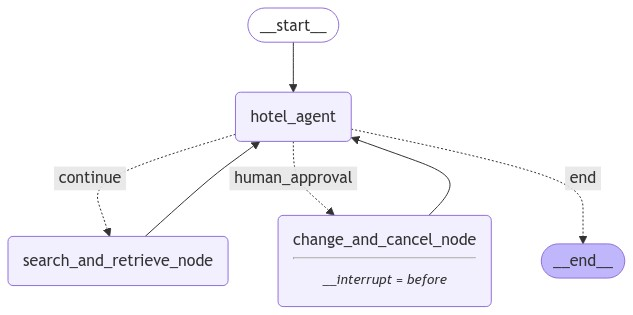

In [ ]:
def _print_event(event: tuple, _printed: set, max_length=1500):
    event_dict = event[1] if isinstance(event, tuple) else event

    # Handle dialog state
    current_state = event_dict.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])

    message = event_dict.get("messages")
    if message:
        if not isinstance(message, list):
            message = [message]

        # Get the last message
        last_message = message[-1]

        message_id = getattr(last_message, "id", str(id(last_message)))

        if message_id not in _printed:
            # Handle pretty printing based on message type
            if hasattr(last_message, "pretty_repr"):
                msg_repr = last_message.pretty_repr(html=True)
            else:
                msg_repr = f"Content: {last_message.content}"
                if hasattr(last_message, "additional_kwargs"):
                    msg_repr += f"\nAdditional info: {last_message.additional_kwargs}"

            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"

            print(msg_repr)
            _printed.add(message_id)

In [ ]:
import uuid
from langchain_core.messages import ToolMessage

thread_id = str(uuid.uuid4())

_printed = set()
config = {"configurable": {"thread_id": thread_id}}

events = hotel_graph_compiled.stream(
    {"messages": ("user", "Get details of my booking id 203")},
    config,
    stream_mode="values",
)
for event in events:
    _print_event(event, _printed)

In [ ]:
thread_id = str(uuid.uuid4())

_printed = set()
config = {"configurable": {"thread_id": thread_id}}

events = hotel_graph_compiled.stream(
    {"messages": ("user", "cancel my hotel booking id 206")},
    config,
    stream_mode="values",
)
for event in events:
    _print_event(event, _printed)

In [ ]:
user_input = input(
    "Do you approve of the above actions? Type 'y' to continue;"
    " otherwise, explain your requested changed.\n\n"
)
if user_input.strip() == "y":
    # Just continue
    result = hotel_graph_compiled.invoke(
        None,
        config,
    )
    result["messages"][-1].pretty_print()
else:
    result = hotel_graph_compiled.invoke(
        {
            "messages": [
                ToolMessage(
                    tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                    content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                )
            ]
        },
        config,
    )
    result["messages"][-1].pretty_print()

## Updating the sate of subgraph

Once we compile the full graph. Hotel agent will be added as a sub graph. We need to update the state of subgraph after the interrupt. 

Now we are ready to test the graph. We will create a unique thread_id to manage memory. We have few sample questions to test the graph.

snapshot retrieves the current state of the supervisor agent graph, which is required to check if there are pending operations or decisions that need user input. The snapshot.next field is checked in the while loop condition to determine if there are any pending operations requiring user approval.

After getting the user input we update the state. While updating the state of subgraph, we need to make sure to pass config of subgraph - `state.tasks[0].state.config` .

If user approves the action, we update the state and invoke the graph `supervisor_agent_graph.invoke(None, config, subgraphs=True)`

If user rejects the action, we update the state with tool message and then continue with the graph.

In [ ]:
def extract_tool_id(pregel_task):
    # Navigate to the messages in the state
    messages = pregel_task.state.values.get("messages", [])

    # Find the last AIMessage
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            # Check if the message has tool_calls
            tool_calls = getattr(message, "tool_calls", None)
            if tool_calls:
                # Return the id of the first tool call
                return tool_calls[0]["id"]

In [ ]:
thread_id = str(uuid.uuid4())
_printed = set()
config = {"configurable": {"thread_id": thread_id}}

questions = [
    "Get details of my flight booking id 200",
    "cancel my hotel booking id 136",
]
for question in questions:
    events = supervisor_agent_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values", subgraphs=True
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = supervisor_agent_graph.get_state(config)
    while snapshot.next:
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue

            supervisor_agent_graph.update_state(
                state.tasks[0].state.config,
                {"messages": "Yes, cancel my booking"},
                as_node="change_and_cancel_node",
            )
            result = supervisor_agent_graph.invoke(None, config, subgraphs=True)
            result_dict = result[1]
            result_dict["messages"][-1].pretty_print()
        else:
            state = supervisor_agent_graph.get_state(config, subgraphs=True)
            tool_id = extract_tool_id(state.tasks[0])
            tool_message = [
                {
                    "tool_call_id": tool_id,
                    "type": "tool",
                    "content": f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                }
            ]
            supervisor_agent_graph.update_state(
                state.tasks[0].state.config,
                {"messages": tool_message},
                as_node="change_and_cancel_node",
            )
            result = supervisor_agent_graph.invoke(None, config, subgraphs=True)
            _print_event(result, _printed)

        snapshot = supervisor_agent_graph.get_state(config)